In [91]:
import pandas as pd
from pathlib import Path
import glob

time_column: str = "Time"


def read_satellite_data(path: Path, threshold: float = 0.2) -> pd.DataFrame:
    all_files = glob.glob(f"{path}/*.csv")
    df = (
        pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        .groupby(time_column, as_index=False)
        .mean()
    )
    df[time_column] = pd.to_datetime(df[time_column]).dt.normalize()
    df = df.select_dtypes(include=["number", "bool", "datetime"])

    non_null_count = df.notnull().sum()
    min_non_null_count = int(threshold * len(df))

    df = df.loc[:, non_null_count >= min_non_null_count]

    return df


satellite_data = read_satellite_data("../data/satellites/lightsail-2")
satellite_columns: list[str] = satellite_data.drop(time_column, axis=1).columns

print(satellite_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Time                          396 non-null    datetime64[ns]
 1   Bat0 Current                  396 non-null    float64       
 2   Bat1 Current                  396 non-null    float64       
 3   Bat2 Current                  396 non-null    float64       
 4   Bat3 Current                  396 non-null    float64       
 5   Bat4 Current                  396 non-null    float64       
 6   Bat5 Current                  396 non-null    float64       
 7   Bat6 Current                  396 non-null    float64       
 8   Bat7 Current                  396 non-null    float64       
 9   Bat0 Voltage                  396 non-null    float64       
 10  Bat1 Voltage                  396 non-null    float64       
 11  Bat2 Voltage                  39

In [92]:
def read_solar_data(file_path: Path, date_column: str) -> pd.DataFrame:
    df = pd.read_json(file_path)
    df[date_column] = pd.to_datetime(df[date_column])
    return df


swpc_observed_ssn = read_solar_data(
    "../data/solar/swpc/swpc_observed_ssn.json", "Obsdate"
)
print(swpc_observed_ssn.info())

swpc_observed_solar_cycle_indicies = read_solar_data(
    "../data/solar/swpc/observed-solar-cycle-indices.json", "time-tag"
)
print(swpc_observed_solar_cycle_indicies.info())

solar_columns: list[str] = (
    swpc_observed_ssn.columns.drop("Obsdate").tolist()
    + swpc_observed_solar_cycle_indicies.columns.drop("time-tag").tolist()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9137 entries, 0 to 9136
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Obsdate   9137 non-null   datetime64[ns]
 1   swpc_ssn  9137 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 142.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time-tag           3309 non-null   datetime64[ns]
 1   ssn                3309 non-null   float64       
 2   smoothed_ssn       3309 non-null   float64       
 3   observed_swpc_ssn  3309 non-null   float64       
 4   smoothed_swpc_ssn  3309 non-null   float64       
 5   f10.7              3309 non-null   float64       
 6   smoothed_f10.7     3309 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory 

In [93]:
dynamics = pd.merge(
    satellite_data, swpc_observed_ssn, left_on=time_column, right_on="Obsdate", how="left"
).drop(columns=["Obsdate"])

dynamics = pd.merge(
    dynamics,
    swpc_observed_solar_cycle_indicies,
    left_on=time_column,
    right_on="time-tag",
    how="left",
).drop(columns=["time-tag"])

print(dynamics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 74 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Time                          396 non-null    datetime64[ns]
 1   Bat0 Current                  396 non-null    float64       
 2   Bat1 Current                  396 non-null    float64       
 3   Bat2 Current                  396 non-null    float64       
 4   Bat3 Current                  396 non-null    float64       
 5   Bat4 Current                  396 non-null    float64       
 6   Bat5 Current                  396 non-null    float64       
 7   Bat6 Current                  396 non-null    float64       
 8   Bat7 Current                  396 non-null    float64       
 9   Bat0 Voltage                  396 non-null    float64       
 10  Bat1 Voltage                  396 non-null    float64       
 11  Bat2 Voltage                  39

In [94]:
import plotly.graph_objects as go


def plot_general_dynamic(df: pd.DataFrame) -> None:
    fig = go.Figure()

    columns: list[str] = [f"{column}" for column in df.columns if column != time_column]

    for column in columns:
        fig.add_trace(
            go.Scatter(
                x=df[time_column],
                y=df[column],
                mode="lines",
                name=column,
                hoverinfo="text",
                text=column,
            )
        )

    fig.update_layout(
        title="Dynamics of Solar Parameters and Lightsail Values Over Time",
        title_x=0.5,
        title_y=0.01,
        xaxis_title="Time",
        yaxis_title="Values",
        xaxis_tickangle=-45,
        legend=dict(
            title="Parameters",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            itemsizing="constant",
        ),
        template="plotly_white",
        margin=dict(l=40, r=40, t=40, b=100),
    )

    fig.show()


def get_normalized_dataframe(df: pd.DataFrame, exclude_column: str) -> pd.DataFrame:
    columns_to_normalize = df.columns[df.columns != exclude_column]

    normalized_df = df.copy()

    normalized_df[columns_to_normalize] = (
        df[columns_to_normalize] - df[columns_to_normalize].mean()
    ) / df[columns_to_normalize].std()

    return normalized_df


normalized_dynamics = get_normalized_dataframe(dynamics, exclude_column=time_column)

plot_general_dynamic(normalized_dynamics)

# Dependency Graph Based on Highest Correlation

In this analysis, we compute the correlation between different variables in a dataset and visualize the relationships using a dependency graph. The following mathematical concepts are involved in this process:

## 1. Correlation Coefficient

The correlation coefficient quantifies the degree to which two variables are related. It is calculated using the formula:

$$
r_{xy} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$


Where:
- $r_{xy}$ is the correlation coefficient between variables $X$ and $Y$.
- $\text{Cov}(X, Y)$ is the covariance between $X$ and $Y$.
- $\sigma_X$ is the standard deviation of variable $X$.
- $\sigma_Y$ is the standard deviation of variable $Y$.

## 2. Covariance

Covariance measures how much two random variables vary together. It is defined as:

$$
\text{Cov}(X, Y) = E\left[(X - E[X])(Y - E[Y])\right]
$$


Where:
- $E[X]$ is the expected value (mean) of $X$.
- $E[Y]$ is the expected value (mean) of $Y$.

## 3. Maximum Correlation

For each variable in the dataset, we find the variable with which it has the highest correlation. This is represented mathematically as:

$$
\text{max\_corr}(X) = \arg\max_{Y} r_{XY}
$$


Where:
- $X$ is a variable from the dataset.
- $Y$ represents all other variables in the dataset.
- $r_{XY}$ is the correlation coefficient between $X$ and $Y$.

## 4. Graph Representation

The relationships are represented as a graph where:
- Each node represents a variable.
- Each edge represents a relationship based on maximum correlation.

### Nodes
Each unique variable is added as a node:

$$
\text{nodes} = \{ "name": X, "name": Y, ...\}
$$


### Edges
An edge is created from each variable to its maximum correlated variable:

$$
\text{edges} = \{ "source": X, "target": Y\}
$$


## Conclusion

The resulting graph visualizes how each variable relates to its most correlated counterpart, providing insights into dependencies within the dataset.


In [95]:
import pandas as pd
from pyecharts import options as opts
from pyecharts.charts import Graph

non_time_measurements = normalized_dynamics.drop(time_column, axis=1)

def render_dependency_graph(df: pd.DataFrame, top_n: int = 5) -> Graph:
    nodes: Graph.Sequence[Graph.GraphNode] = []
    edges: Graph.Sequence[Graph.GraphLink] = []

    correlation_matrix = df.corr()

    for column in df.columns:
        correlations = correlation_matrix[column].drop(column).dropna()

        if not correlations.empty:
            top_correlations = correlations.nlargest(top_n)

            for _, (corr_col, corr_value) in enumerate(top_correlations.items()):
                if {"name": column} not in nodes:
                    nodes.append({"name": column})
                if {"name": corr_col} not in nodes:
                    nodes.append({"name": corr_col})

                edges.append({"source": column, "target": corr_col, "value": corr_value})

    return (
        Graph()
        .add("", nodes=nodes, links=edges, layout="circular", is_rotate_label=True)
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="Dependency Graph Based on Highest Correlations"
            ),
            tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{c}"),
        )
    )

render_dependency_graph(non_time_measurements, top_n=5).render_notebook()

In [109]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Определите ваш солнечный столбец
solar_column = solar_columns[0]

# Установите параметры по умолчанию
default_xgb_params = {
    'learning_rate': 0.01,  # Уменьшите скорость обучения
    'gamma': 0,
    'max_depth': 6,  # Попробуйте уменьшить глубину дерева
    'n_estimators': 500,  # Увеличьте количество деревьев
    'base_score': 0.5,
    'colsample_bylevel': 1,
    'colsample_bytree': 1,
    'max_delta_step': 0,
    'min_child_weight': 1,
    'missing': np.nan,
    'nthread': 100,
    'objective': "reg:squarederror",
    'reg_alpha': 0.1,  # Добавьте L1 регуляризацию
    'reg_lambda': 1,   # L2 регуляризация
    'scale_pos_weight': 1,
    'seed': 0,
    'verbosity': 1,
    'subsample': 0.8,
    'tree_method': "auto"
}

# Заполнение пропусков в данных
xgb_source = non_time_measurements.fillna(0)
X = xgb_source[satellite_columns]
y = xgb_source[solar_column]

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Разделение данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Создание и обучение модели с ранней остановкой
model = XGBRegressor(**default_xgb_params)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=True)

# Оценка модели на валидационной выборке
validation_score = model.score(X_valid, y_valid)
print(f"Validation Score: {validation_score:.4f}")

# Кросс-валидация для более надежной оценки модели
cross_val_scores = cross_val_score(model, X_imputed, y, cv=5)
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cross_val_scores):.4f}")


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [98]:
import plotly.express as px
import numpy as np

importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': satellite_columns,
    'Importance': importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(importance_df, x='Feature', y='Importance',
             title='Feature Importances from XGBRegressor',
             labels={'Importance': 'Importance Score'},
             color='Importance',
             text='Importance')

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_title='Features', yaxis_title='Importance Score',
                  xaxis_tickangle=-45)

fig.show()


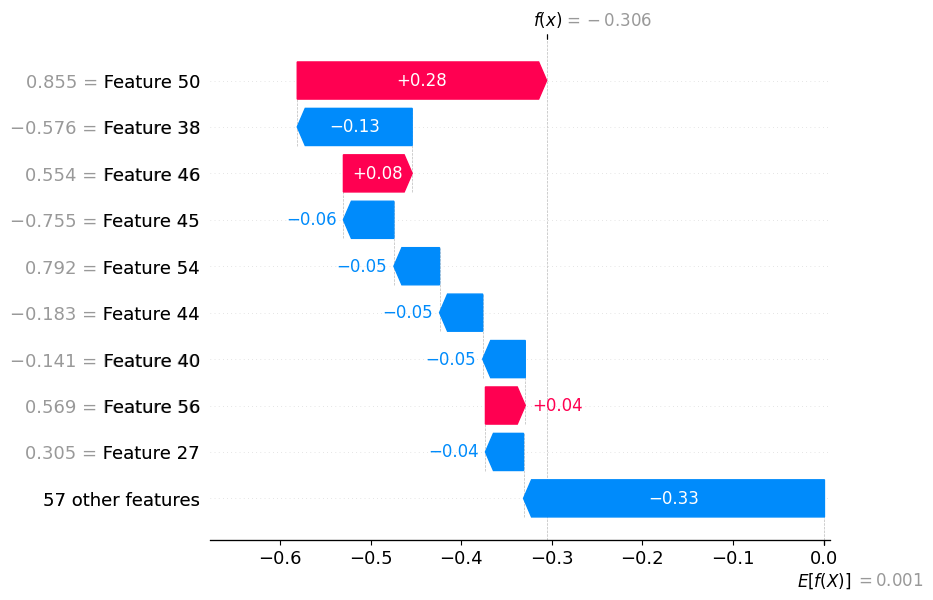

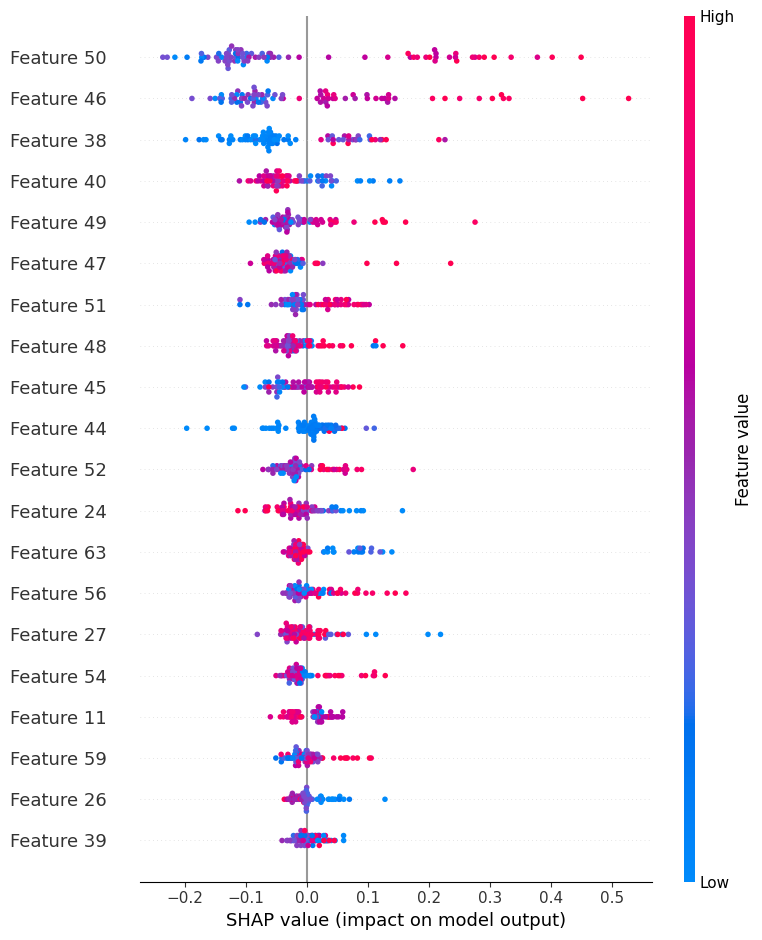

In [102]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_valid)

shap.plots.waterfall(shap_values[0])

shap.summary_plot(shap_values, X_valid)

In [106]:
nodes = [{"name": row['Feature'], "value": row['Importance']} for _, row in importance_df.iterrows()]
links = []

for i in range(1, len(nodes)):
    links.append({"source": nodes[i-1]['name'], "target": nodes[i]['name']})

graph = (
    Graph()
    .add("", nodes, links)
    .set_global_opts(title_opts=opts.TitleOpts(title="Feature Importance Dependency Graph"))
)

graph.render_notebook()